# Overview

**This cell is intended for development use and may be removed upon project completion**

Plan of approach:
- ~~Buy and Hold (Null Model)~~
- Monte Carlo Simulation
- Advanced Strategies
    - Mean Reversion
    - Momentum
    - Pairs Trading
- Performance Evaluation
    - Walk-Forward Backtesting
    - Management/Brokerage Fees
    - Alpha
    - Beta
    - Sharpe Ratio

## Imports

In [46]:
import math
import os
import time
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

from pathlib import Path
from typing import Dict, Iterable, List

import jinja2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow
import polars as pl
import seaborn as sns
import yfinance as yf
from dotenv import load_dotenv
from fredapi import Fred
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

In [47]:
env_path = Path.cwd().parent / ".env"
load_dotenv(dotenv_path=env_path)

True

## Constants

### Paths

In [48]:
repo_root = Path.cwd().parent
data_dir = repo_root / "data"
results_dir = repo_root / "results"
results_dir.mkdir(parents=True, exist_ok=True)

### Monte Carlo

In [49]:
YEARS = 5
TRADING_DAYS_PER_YEAR = 252
N_DAYS = YEARS * TRADING_DAYS_PER_YEAR

# Random portfolio sampling controls
N_RANDOM_PORTFOLIOS = 500          # number of distinct random weight vectors to sample per scenario
N_PATHS_PER_PORTFOLIO = 200        # number of Monte Carlo paths per random portfolio
SEED = 12345

# Long+Short structure (gross/net exposure)
# Example 1.0/1.0 ≈ unit gross exposure; for 130/30: NET_EXPOSURE=1.0, GROSS_EXPOSURE=1.6
NET_EXPOSURE   = 1.0               # sum(weights) target for long+short
GROSS_EXPOSURE = 1.0               # sum(abs(weights)) target for long+short base scenario

START_VALUE = 1_000_000
REBALANCE_MAP = {"Daily": 1, "Weekly": 5, "Monthly": 21}  # trading-day steps

n_assets = None

## Functions

### Download Ticker Data

In [50]:
def download_ticker_data(tickers: Iterable[str], start: str, end: str, dest_dir: str = "data", retries: int = 3, pause: float = 1.0) -> List[str]:
    """
    Downloads historical stock data for a list of tickers using yfinance and saves each to a CSV file.

    Parameters
    ----------
    tickers : Iterable[str]
        List or iterable of ticker symbols to download.
    start : str
        Start date for historical data in 'YYYY-MM-DD' format.
    end : str
        End date for historical data in 'YYYY-MM-DD' format.
    dest_dir : str, optional
        Directory to save CSV files (default is "data").
    retries : int, optional
        Number of retry attempts for each ticker if download fails (default is 3).
    pause : float, optional
        Seconds to wait between retries (default is 1.0).

    Returns
    -------
    List[str]
        List of file paths to the saved CSV files.
    """
    cwd = Path.cwd()
    dest_path = Path(dest_dir)
    if dest_path.is_absolute():
        dest = dest_path
    else:
        dest = cwd.parent / dest_path
    dest.mkdir(parents=True, exist_ok=True)
    saved_files: List[str] = []
    for t in tickers:
        t = str(t).upper().strip()
        out_path = dest / f"{t}.csv"
        attempt = 0
        while attempt < retries:
            try:
                print(f"Downloading data for {t} (attempt {attempt+1}/{retries}) from {start} to {end} ...")
                ticker = yf.Ticker(t)
                historical_data = ticker.history(start=start, end=end)
                if historical_data is None or historical_data.empty:
                    raise ValueError(f"No data returned for {t} (start={start}, end={end})")
                historical_data.to_csv(out_path)
                print(f"Data for {t} saved to {out_path}")
                saved_files.append(str(out_path))
                break
            except Exception as exc:
                attempt += 1
                print(f"Failed to download {t}: {exc}")
                if attempt < retries:
                    print(f"Retrying after {pause} seconds...")
                    time.sleep(pause)
                else:
                    print(f"Giving up on {t} after {retries} attempts.")
    return saved_files

### Compute Absolute Return

In [51]:
def compute_absolute_return(df: pl.DataFrame) -> np.ndarray:
    """
    Compute cumulative (absolute) return series from a price DataFrame, including dividends.

    Parameters
    ----------
    df : polars.DataFrame
        Input must contain columns:
        - 'Date' : sortable date-like values (string/datetime). Function sorts ascending by this column.
        - 'Close' : closing prices (numeric).
        - Optional 'Dividends' : cash dividends (numeric). If missing, treated as zeros.

    Returns
    -------
    numpy.ndarray
        1D array of cumulative growth factors (length == number of rows).
        - First element is 1.0 (initial capital).
        - Each subsequent element is cumulative product of (1 + daily_total_return),
          where daily_total_return = price_return + dividend_return.
        - Empty input returns an empty array.

    Notes
    -----
    - Uses polars operations and numpy for numeric computation.
    - Dividend return for day t is Dividends[t] / Close[t-1]; first-day dividend return is treated as 0.
    - Handles NaNs and division-by-zero safely.
    """
    df = df.sort('Date')
    close = np.asarray(df['Close'].to_list(), dtype=float)
    if 'Dividends' in df.columns:
        divs = np.asarray(df['Dividends'].to_list(), dtype=float)
    else:
        divs = np.zeros(len(close), dtype=float)
    if len(close) == 0:
        return np.array([], dtype=float)
    price_ret = np.zeros_like(close, dtype=float)
    if len(close) > 1:
        price_ret[1:] = (close[1:] - close[:-1]) / close[:-1]
    prev_close = np.concatenate(([np.nan], close[:-1]))
    with np.errstate(divide='ignore', invalid='ignore'):
        div_ret = np.where(np.isnan(prev_close), 0.0, divs / prev_close)
    div_ret = np.nan_to_num(div_ret, 0.0)
    total_daily = np.nan_to_num(price_ret, 0.0) + div_ret
    cumulative = np.cumprod(1.0 + total_daily)
    cumulative[0] = 1.0
    return cumulative

### Weight Generators

In [52]:
def sample_long_only_weights(n_assets, rng):
    """Random long-only weights on the simplex (sum=1, all >=0)."""
    w = rng.random(n_assets)
    s = w.sum()
    if s == 0:
        # extremely unlikely, but guard anyway
        w = np.ones(n_assets) / n_assets
    else:
        w = w / s
    return w

In [53]:
def sample_long_short_weights(n_assets, rng, net=1.0, gross=1.0):
    """
    Random long+short weights:
      - Start with normal draws (positive & negative).
      - First normalize to target gross: sum(|w|)=gross
      - Then shift minimally to target net: sum(w)=net (preserve relative signs)
    """
    w = rng.standard_normal(n_assets)
    if np.allclose(w, 0):
        w = rng.standard_normal(n_assets)

    # Normalize to target gross exposure
    gross_current = np.sum(np.abs(w))
    if gross_current == 0:
        w = np.sign(rng.standard_normal(n_assets)) / n_assets
        gross_current = np.sum(np.abs(w))
    w = w * (gross / gross_current)

    # Adjust to target net exposure (shift by a constant c)
    # sum(w + c) = net  =>  c = (net - sum(w)) / n_assets
    c = (net - np.sum(w)) / n_assets
    w = w + c

    # If gross changed too much after shifting, renormalize slightly (soft fix)
    gross_after = np.sum(np.abs(w))
    if not np.isclose(gross_after, gross, rtol=1e-2, atol=1e-3):
        w = w * (gross / gross_after)

    return w

### Monte Carlo

In [54]:
def simulate_asset_returns(mu, L, n_steps, n_paths, rng):
    """
    Simulate multivariate daily log returns:
      r_t ~ N(mu, cov) with cov = L L^T
    Returns array shape: (n_paths, n_steps, n_assets)
    """
    Z = rng.standard_normal(size=(n_paths, n_steps, L.shape[0]))
    # Correlate last dim: (n_paths*n_steps, n_assets) @ L.T then reshape back
    Z2 = Z.reshape(-1, L.shape[0]) @ L.T
    Zc = Z2.reshape(n_paths, n_steps, L.shape[0])
    # Add mean (mu) to each step
    return mu[None, None, :] + Zc

In [55]:
def simulate_portfolio_paths(weights, logret_paths, rebalance_step, start_value=START_VALUE):
    """
    Given weights (1D), simulated log-return paths (n_paths, n_steps, n_assets),
    and a rebalancing step in trading days, compute portfolio value paths.
    Rebalances to target weights every 'rebalance_step' days.
    Returns: (n_paths, n_steps+1) portfolio values.
    """
    n_paths, n_steps, n_assets = logret_paths.shape
    pv = np.empty((n_paths, n_steps + 1))
    pv[:, 0] = start_value

    # convert log-returns to arithmetic returns each step
    ret = np.exp(logret_paths) - 1.0  # (n_paths, n_steps, n_assets)

    # Start with target weights
    current_w = np.tile(weights, (n_paths, 1))  # (n_paths, n_assets)

    for t in range(1, n_steps + 1):
        # portfolio arithmetic return at step t-1 (since pv at t uses ret at t-1)
        step_ret = (current_w * ret[:, t - 1, :]).sum(axis=1)  # shape (n_paths,)
        pv[:, t] = pv[:, t - 1] * (1.0 + step_ret)

        # drift of weights due to differential returns
        # new weights before rebalance:
        # w_i' = w_i * (1 + r_i) / (1 + r_p)
        denom = (1.0 + step_ret)[:, None]
        current_w = current_w * (1.0 + ret[:, t - 1, :]) / np.where(denom == 0, 1.0, denom)

        # rebalance if needed
        if (t % rebalance_step) == 0:
            current_w = np.tile(weights, (n_paths, 1))

    return pv

In [56]:
def summarize_terminal(terminal_values, label):
    mean_v = terminal_values.mean()
    med_v = np.median(terminal_values)
    var95 = np.percentile(terminal_values, 5)
    cvar95 = terminal_values[terminal_values <= var95].mean()
    return pd.Series(
        {"Mean": mean_v, "Median": med_v, "VaR_5%": var95, "CVaR_5%": cvar95, "N": len(terminal_values)},
        name=label,
    )

In [57]:
def _safe_cholesky(C):
    try:
        return np.linalg.cholesky(C)
    except np.linalg.LinAlgError:
        eps = 1e-10
        return np.linalg.cholesky(C + np.eye(C.shape[0]) * eps)

In [58]:
def run_random_portfolio_monte_carlo(
    mu, L, n_days, n_random_portfolios, n_paths_per_portfolio, rng, rebalance_step,
    long_only=True, net_exposure=1.0, gross_exposure=1.0
):
    """
    For each random portfolio:
      1) sample weights (long-only or long+short)
      2) simulate asset log-returns (shared across portfolios for fairness or unique — here unique per portfolio)
      3) compute portfolio value path with periodic rebalancing
    Returns a flat array of all terminal values across (portfolios × paths), and a DataFrame of per-portfolio stats.
    """
    all_terminals = []
    per_portfolio_rows = []

    for i in range(n_random_portfolios):
        w = (
            sample_long_only_weights(n_assets, rng)
            if long_only
            else sample_long_short_weights(n_assets, rng, net=net_exposure, gross=gross_exposure)
        )

        # simulate new paths for this portfolio
        logret_paths = simulate_asset_returns(mu, L, n_days, n_paths_per_portfolio, rng)
        pv = simulate_portfolio_paths(w, logret_paths, rebalance_step, start_value=START_VALUE)
        terminal = pv[:, -1]
        all_terminals.append(terminal)

        # record per-portfolio stats (using the average across its paths)
        per_portfolio_rows.append(
            {
                "mean_terminal": terminal.mean(),
                "median_terminal": np.median(terminal),
                "std_terminal": terminal.std(ddof=1),
                "min_terminal": terminal.min(),
                "max_terminal": terminal.max(),
                "gross_exposure": np.sum(np.abs(w)),
                "net_exposure": np.sum(w),
            }
        )

    all_terminals = np.concatenate(all_terminals, axis=0)
    per_portfolio_df = pd.DataFrame(per_portfolio_rows)
    return all_terminals, per_portfolio_df

## Data Ingestion

### Yahoo Finance

In [59]:
tickers = ["PG", "KO", "PEP", "COST", "WMT"]
benchmarks = ['IYK','VDC','XLP']
start_date = "2000-01-01"
end_date = "2025-01-01"

saved_tickers = download_ticker_data(tickers, start_date, end_date)
print(saved_tickers, "\n")

saved_benchmarks = download_ticker_data(benchmarks, start_date, end_date)
print(saved_benchmarks, "\n")

saved_vix = download_ticker_data(["^VIX"], start_date, end_date)
print(saved_vix)

Data for PG saved to c:\Users\elibf\Documents\Repositories\MSDS-451-Final\data\PG.csv
Data for KO saved to c:\Users\elibf\Documents\Repositories\MSDS-451-Final\data\KO.csv
Data for PEP saved to c:\Users\elibf\Documents\Repositories\MSDS-451-Final\data\PEP.csv
Data for COST saved to c:\Users\elibf\Documents\Repositories\MSDS-451-Final\data\COST.csv
Data for WMT saved to c:\Users\elibf\Documents\Repositories\MSDS-451-Final\data\WMT.csv
['c:\\Users\\elibf\\Documents\\Repositories\\MSDS-451-Final\\data\\PG.csv', 'c:\\Users\\elibf\\Documents\\Repositories\\MSDS-451-Final\\data\\KO.csv', 'c:\\Users\\elibf\\Documents\\Repositories\\MSDS-451-Final\\data\\PEP.csv', 'c:\\Users\\elibf\\Documents\\Repositories\\MSDS-451-Final\\data\\COST.csv', 'c:\\Users\\elibf\\Documents\\Repositories\\MSDS-451-Final\\data\\WMT.csv'] 

Data for IYK saved to c:\Users\elibf\Documents\Repositories\MSDS-451-Final\data\IYK.csv
Data for VDC saved to c:\Users\elibf\Documents\Repositories\MSDS-451-Final\data\VDC.csv
Data

In [60]:
pg_data = pl.read_csv(saved_tickers[0])
ko_data = pl.read_csv(saved_tickers[1])
pep_data = pl.read_csv(saved_tickers[2])
cost_data = pl.read_csv(saved_tickers[3])
wmt_data = pl.read_csv(saved_tickers[4])
vix_data = pl.read_csv(saved_vix[0])

### Federal Reserve Economic Data

In [61]:
fred = Fred(api_key=os.getenv("FRED_API_KEY"))

In [62]:
indicators = {
    'GDP': 'A191RL1Q225SBEA', # Real Gross Domestic Product
    'CPI': 'CPIAUCSL', # Consumer Price Index for All Urban Consumers: All Items
    'UNRATE': 'UNRATE', # Unemployment Rate
    'FEDFUNDS': 'FEDFUNDS', # Effective Federal Funds Rate
    'VIX': 'VIXCLS', # CBOE Volatility Index
    'T10Y3M': 'T10Y3M' # 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity
}

In [63]:
fred_dfs: Dict[str, pl.DataFrame] = {}

for name, code in indicators.items():
    series = fred.get_series(code)
    # handle empty or missing series
    if series is None or len(series) == 0:
        fred_dfs[name] = pl.DataFrame({})
        continue

    # If the series has an index, align values to index; otherwise treat as sequence
    try:
        idx = list(series.index)
        dates = [d for d in idx]
        values = []
        for v in series.values:
            if isinstance(v, float) and math.isnan(v):
                values.append(None)
            else:
                values.append(v)
    except Exception:
        vals_list = list(series)
        dates = list(range(len(vals_list)))
        values = [None if (isinstance(v, float) and math.isnan(v)) else v for v in vals_list]

    df = pl.DataFrame({"DATE": dates, name: values})
    try:
        df = df.with_column(pl.col("DATE").str.strptime(pl.Date, "%Y-%m-%d").alias("DATE"))
    except Exception:
        pass

    fred_dfs[name] = df

## Exploratory Data Analysis

### Procter & Gamble ($PG)

In [64]:
pg_data.schema

Schema([('Date', String),
        ('Open', Float64),
        ('High', Float64),
        ('Low', Float64),
        ('Close', Float64),
        ('Volume', Int64),
        ('Dividends', Float64),
        ('Stock Splits', Float64)])

In [65]:
pg_data.head()

Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
str,f64,f64,f64,f64,i64,f64,f64
"""2000-01-03 00:00:00-05:00""",27.181797,27.213312,26.64604,27.024221,4275000,0.0,0.0
"""2000-01-04 00:00:00-05:00""",26.819372,27.323614,26.157555,26.504221,4270800,0.0,0.0
"""2000-01-05 00:00:00-05:00""",26.441179,26.56724,25.842392,25.999968,5098400,0.0,0.0
"""2000-01-06 00:00:00-05:00""",26.504219,27.591491,26.488461,27.197552,6524200,0.0,0.0
"""2000-01-07 00:00:00-05:00""",27.623013,29.498163,27.528468,29.372103,9832000,0.0,0.0


In [66]:
pg_data.describe()

statistic,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""6289""",6289.0,6289.0,6289.0,6289.0,6289.0,6289.0,6289.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,62.483817,62.956027,62.040351,62.515747,9.0132e6,0.008592,0.000318
"""std""",null,40.718832,41.015665,40.448533,40.736321,5.6135e6,0.074331,0.02522
"""min""","""2000-01-03 00:00:00-05:00""",13.588685,13.921862,13.335877,13.58869,1.0304e6,0.0,0.0
"""25%""",null,32.09747,32.335117,31.839747,32.124336,6.0772e6,0.0,0.0
"""50%""",null,45.112698,45.38238,44.977858,45.180107,7.7066e6,0.0,0.0
"""75%""",null,74.418123,74.806473,74.094487,74.490913,1.02841e7,0.0,0.0
"""max""","""2024-12-31 00:00:00-05:00""",175.366797,175.785721,174.129482,175.074509,1.372872e8,1.007,2.0


### Coca-Cola ($KO)

In [67]:
ko_data.head()

Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
str,f64,f64,f64,f64,i64,f64,f64
"""2000-01-03 00:00:00-05:00""",14.105789,14.105789,13.43698,13.710584,10997000,0.0,0.0
"""2000-01-04 00:00:00-05:00""",13.710576,13.816978,13.528174,13.725777,7308000,0.0,0.0
"""2000-01-05 00:00:00-05:00""",13.725781,13.968984,13.63458,13.847383,9457400,0.0,0.0
"""2000-01-06 00:00:00-05:00""",13.847381,14.029783,13.75618,13.862581,7129200,0.0,0.0
"""2000-01-07 00:00:00-05:00""",14.075386,14.774595,14.075386,14.774595,11474000,0.0,0.0


### PepsiCo ($PEP)

In [68]:
pep_data.describe()

statistic,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""6289""",6289.0,6289.0,6289.0,6289.0,6289.0,6289.0,6289.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,68.497355,69.003208,67.9811,68.51309,5.2211e6,0.009602,0.0
"""std""",null,45.383347,45.676967,45.038633,45.363775,2.5435e6,0.088107,0.0
"""min""","""2000-01-03 00:00:00-05:00""",15.728742,16.055061,15.43199,15.919316,772100.0,0.0,0.0
"""25%""",null,32.407457,32.839276,31.954478,32.480553,3.6481e6,0.0,0.0
"""50%""",null,46.695442,47.003783,46.459051,46.717793,4.6604e6,0.0,0.0
"""75%""",null,92.291248,92.764964,91.617712,92.273811,6.047e6,0.0,0.0
"""max""","""2024-12-31 00:00:00-05:00""",180.996814,181.282253,179.505138,180.582443,3.49637e7,1.355,0.0


### Costco ($COST)

In [69]:
cost_data.describe()

statistic,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""6289""",6289.0,6289.0,6289.0,6289.0,6289.0,6289.0,6289.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,161.111292,162.545946,159.678819,161.193356,3.2875e6,0.012762,0.000318
"""std""",null,198.222968,199.876043,196.486752,198.293983,2.4008e6,0.273506,0.02522
"""min""","""2000-01-03 00:00:00-05:00""",18.210824,18.418222,17.352805,18.224205,103300.0,0.0,0.0
"""25%""",null,33.621663,34.058359,33.141831,33.618446,1.8563e6,0.0,0.0
"""50%""",null,68.561345,69.103927,68.319416,68.737328,2.6263e6,0.0,0.0
"""75%""",null,197.173986,198.964928,196.123791,197.319458,4.0082e6,0.0,0.0
"""max""","""2024-12-31 00:00:00-05:00""",997.889962,1004.435155,989.830639,990.926453,5.67735e7,15.0,2.0


### Walmart ($WMT)

In [70]:
wmt_data.describe()

statistic,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""6289""",6289.0,6289.0,6289.0,6289.0,6289.0,6289.0,6289.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,22.78234,22.974651,22.597028,22.788474,3.1036e7,0.001884,0.000477
"""std""",null,15.482651,15.590558,15.376946,15.48933,1.9701e7,0.016767,0.037829
"""min""","""2000-01-03 00:00:00-05:00""",8.982413,9.396777,8.862113,9.249745,6.0942e6,0.0,0.0
"""25%""",null,11.756285,11.882748,11.61396,11.747664,1.87569e7,0.0,0.0
"""50%""",null,16.405392,16.581081,16.313523,16.419308,2.52381e7,0.0,0.0
"""75%""",null,28.781936,29.062351,28.584454,28.773535,3.70059e7,0.0,0.0
"""max""","""2024-12-31 00:00:00-05:00""",94.756085,95.251255,94.409464,94.775887,2.903604e8,0.208,3.0


### FRED

In [71]:
fred_dfs.keys()

dict_keys(['GDP', 'CPI', 'UNRATE', 'FEDFUNDS', 'VIX', 'T10Y3M'])

In [72]:
fred_dfs['GDP'].head()

DATE,GDP
datetime[μs],f64
1947-04-01 00:00:00,-1.0
1947-07-01 00:00:00,-0.8
1947-10-01 00:00:00,6.4
1948-01-01 00:00:00,6.2
1948-04-01 00:00:00,6.8


In [73]:
fred_dfs['CPI'].head()

DATE,CPI
datetime[μs],f64
1947-01-01 00:00:00,21.48
1947-02-01 00:00:00,21.62
1947-03-01 00:00:00,22.0
1947-04-01 00:00:00,22.0
1947-05-01 00:00:00,21.95


In [74]:
fred_dfs['UNRATE'].head()

DATE,UNRATE
datetime[μs],f64
1948-01-01 00:00:00,3.4
1948-02-01 00:00:00,3.8
1948-03-01 00:00:00,4.0
1948-04-01 00:00:00,3.9
1948-05-01 00:00:00,3.5


In [75]:
fred_dfs['FEDFUNDS'].head()

DATE,FEDFUNDS
datetime[μs],f64
1954-07-01 00:00:00,0.8
1954-08-01 00:00:00,1.22
1954-09-01 00:00:00,1.07
1954-10-01 00:00:00,0.85
1954-11-01 00:00:00,0.83


In [76]:
fred_dfs['VIX'].head()

DATE,VIX
datetime[μs],f64
1990-01-02 00:00:00,17.24
1990-01-03 00:00:00,18.19
1990-01-04 00:00:00,19.22
1990-01-05 00:00:00,20.11
1990-01-08 00:00:00,20.26


In [77]:
fred_dfs['T10Y3M'].head()

DATE,T10Y3M
datetime[μs],f64
1982-01-04 00:00:00,2.32
1982-01-05 00:00:00,2.24
1982-01-06 00:00:00,2.43
1982-01-07 00:00:00,2.46
1982-01-08 00:00:00,2.5


## Modeling

Assignment Link: https://canvas.northwestern.edu/courses/240685/assignments/1626619

### Null Models

Before investigating how different features, models, and approaches can impact the performance of the fund, it is valuable to investigate how this portfolio would perform with no action taken at all. In other words, how would this fund perform if it were to only buy, hold, and reinvest dividends into the core positions over an extended period of time? Will this be more or less profitable than actively trading the assets? Additionally, are there extended periods of time where the portfolio is overall down or getting outpaced by other consumer staples ETFs?

These questions are important to answer, as investors in this consumer staples ETF are interested in a defensive holding that maintains reliable returns, but they are also interested in ensuring that this ETF has benefits over alternatives that re-balance on a quarterly basis. If this ETF has extended periods of low or negative returns, or is outpaced in the long run by competitors, investors are going to move their assets elsewhere.

In [78]:
# TODO: Implement analysis from `null_model.ipynb`

# Compute cumulative arrays per ticker
cum_arrays = {}
for t in tickers + benchmarks:
    path = data_dir / f'{t}.csv'
    if not path.exists():
        continue
    df = pl.read_csv(path)
    if 'Date' not in df.columns or 'Close' not in df.columns:
        continue
    # coerce Date strings to numpy datetime64 if necessary
    date_list = [str(x) for x in df['Date'].to_list()]
    dates_np = np.array(date_list, dtype='datetime64[ms]')
    if 'Dividends' not in df.columns:
        df = df.with_columns([pl.lit(0.0).alias('Dividends')])
    vals = compute_absolute_return(df)
    mask = ~np.isnat(dates_np)
    if not mask.any():
        continue
    dates_np = dates_np[mask]
    vals = vals[mask]
    cum_arrays[t] = (dates_np, vals)

# Determine analysis start
starts = [v[0][0] for v in cum_arrays.values()] if len(cum_arrays)>0 else [np.datetime64('2000-01-01')]
common_start = max(np.datetime64('2000-01-01'), *starts)
print('Analysis start date:', np.datetime_as_string(common_start, unit='D'))

# Build union date grid and align series to it (last-known-value / asof)
all_dates = np.unique(np.concatenate([v[0] for v in cum_arrays.values()])) if cum_arrays else np.array([], dtype='datetime64[ms]')
all_dates = all_dates[all_dates >= common_start]
aligned = {'Date': all_dates}
for t, (dates_np, vals_np) in cum_arrays.items():
    idxs = np.searchsorted(dates_np, all_dates, side='right') - 1
    idxs[idxs < 0] = 0
    filled = vals_np[np.clip(idxs, 0, len(vals_np)-1)]
    aligned[t] = filled
aligned_pl = pl.DataFrame(aligned)
# compute equal-weight portfolio across available tickers
ticker_cols = [c for c in aligned_pl.columns if c != 'Date']
if ticker_cols:
    arrs = np.vstack([np.asarray(aligned_pl[c].to_numpy(), dtype=float) for c in ticker_cols]).T
    portfolio_vals = np.nanmean(arrs, axis=1)
else:
    portfolio_vals = np.array([], dtype=float)
aligned_pl = aligned_pl.with_columns([pl.Series('PORTFOLIO', portfolio_vals)])

Analysis start date: 2004-01-30


#### Linear Growth (Tickers + Benchmarks + Portfolio)

Saved: c:\Users\elibf\Documents\Repositories\MSDS-451-Final\results\all_assets_portfolio_benchmarks_linear.png


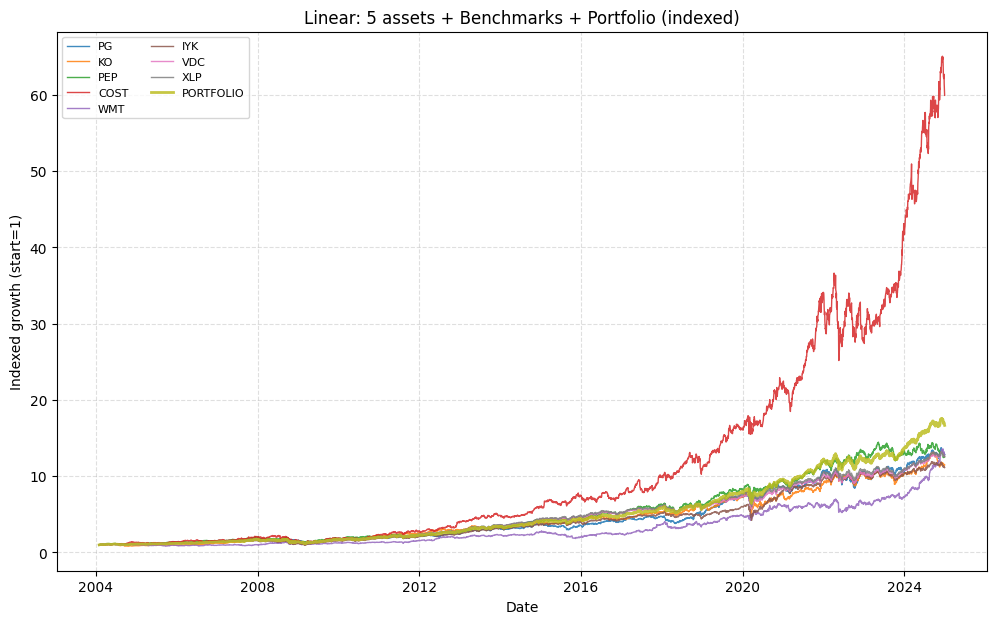

In [79]:
# Plot 1: Linear returns - 5 assets + portfolio + benchmarks (indexed to start)
dates = aligned_pl['Date'].to_numpy()
plt.figure(figsize=(12,7))
cols = [c for c in aligned_pl.columns if c not in ('Date',)]
# prefer the 5 core tickers first (if present)
plot_order = [t for t in ['PG','KO','PEP','COST','WMT'] if t in cols]
# add any benchmarks present
plot_order += [b for b in benchmarks if b in cols and b not in plot_order]
# finally add portfolio
if 'PORTFOLIO' in cols:
    plot_order.append('PORTFOLIO')
for col in plot_order:
    y = np.asarray(aligned_pl[col].to_numpy(), dtype=float)
    base = y[0] if len(y)>0 else np.nan
    y_norm = y if base==0 or np.isnan(base) else y/base
    plt.plot(dates, y_norm, label=col, linewidth=2 if col=='PORTFOLIO' else 1, alpha=0.85)
plt.xlabel('Date')
plt.ylabel('Indexed growth (start=1)')
plt.title('Linear: 5 assets + Benchmarks + Portfolio (indexed)')
plt.legend(ncol=2, fontsize=8)
plt.grid(True, ls='--', alpha=0.4)
png = results_dir / 'all_assets_portfolio_benchmarks_linear.png'
plt.savefig(png, bbox_inches='tight', dpi=150)
print('Saved:', png)
plt.show()

#### Log Growth (Tickers + Benchmarks + Portfolio)

Saved: c:\Users\elibf\Documents\Repositories\MSDS-451-Final\results\all_assets_portfolio_benchmarks_log.png


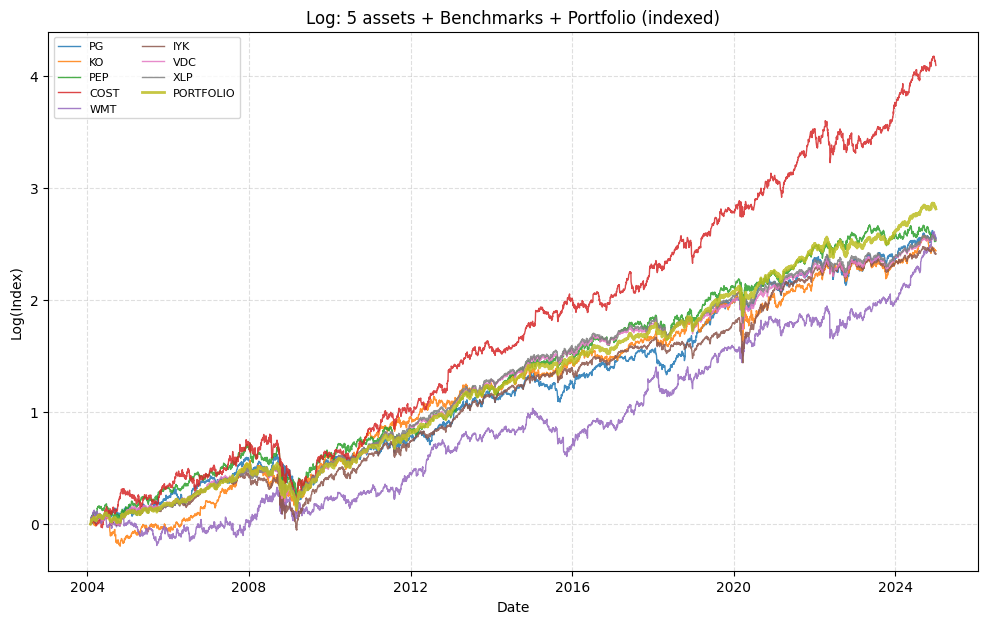

In [80]:
# Plot 2: Log-transformed returns - 5 assets + portfolio + benchmarks
dates = aligned_pl['Date'].to_numpy()
plt.figure(figsize=(12,7))
for col in plot_order:
    y = np.asarray(aligned_pl[col].to_numpy(), dtype=float)
    base = y[0] if len(y)>0 else np.nan
    y_norm = y if base==0 or np.isnan(base) else y/base
    y_log = np.where(y_norm>0, np.log(y_norm), np.nan)
    plt.plot(dates, y_log, label=col, linewidth=2 if col=='PORTFOLIO' else 1, alpha=0.85)
plt.xlabel('Date')
plt.ylabel('Log(Index)')
plt.title('Log: 5 assets + Benchmarks + Portfolio (indexed)')
plt.legend(ncol=2, fontsize=8)
plt.grid(True, ls='--', alpha=0.4)
png = results_dir / 'all_assets_portfolio_benchmarks_log.png'
plt.savefig(png, bbox_inches='tight', dpi=150)
print('Saved:', png)
plt.show()

#### Linear Growth (Portfolio vs Benchmarks)

Saved: c:\Users\elibf\Documents\Repositories\MSDS-451-Final\results\portfolio_vs_benchmarks_linear.png


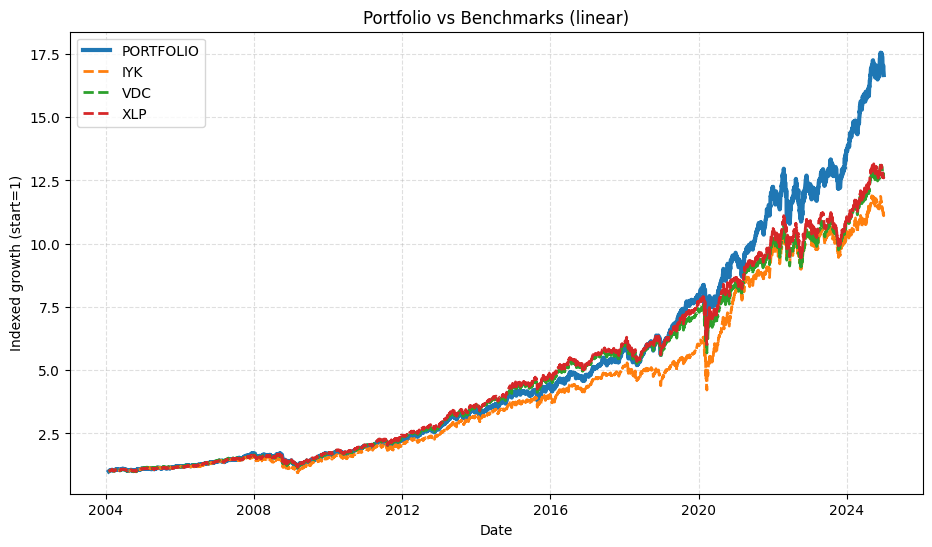

In [81]:
# Plot 3: Portfolio vs Benchmarks (linear) - only portfolio and benchmarks
dates = aligned_pl['Date'].to_numpy()
plt.figure(figsize=(11,6))
series_names = []
if 'PORTFOLIO' in aligned_pl.columns:
    series_names.append('PORTFOLIO')
for b in benchmarks:
    if b in aligned_pl.columns:
        series_names.append(b)
for name in series_names:
    arr = np.asarray(aligned_pl[name].to_numpy(), dtype=float)
    base = arr[0] if len(arr)>0 else np.nan
    arr = arr if base==0 or np.isnan(base) else arr/base
    plt.plot(dates, arr, label=name, linewidth=3 if name=='PORTFOLIO' else 2, linestyle='--' if name!='PORTFOLIO' else '-')
plt.xlabel('Date')
plt.ylabel('Indexed growth (start=1)')
plt.title('Portfolio vs Benchmarks (linear)')
plt.legend()
plt.grid(True, ls='--', alpha=0.4)
png = results_dir / 'portfolio_vs_benchmarks_linear.png'
plt.savefig(png, bbox_inches='tight', dpi=150)
print('Saved:', png)
plt.show()

#### Log Growth (Portfolio vs Benchmarks)

Saved: c:\Users\elibf\Documents\Repositories\MSDS-451-Final\results\portfolio_vs_benchmarks_log.png


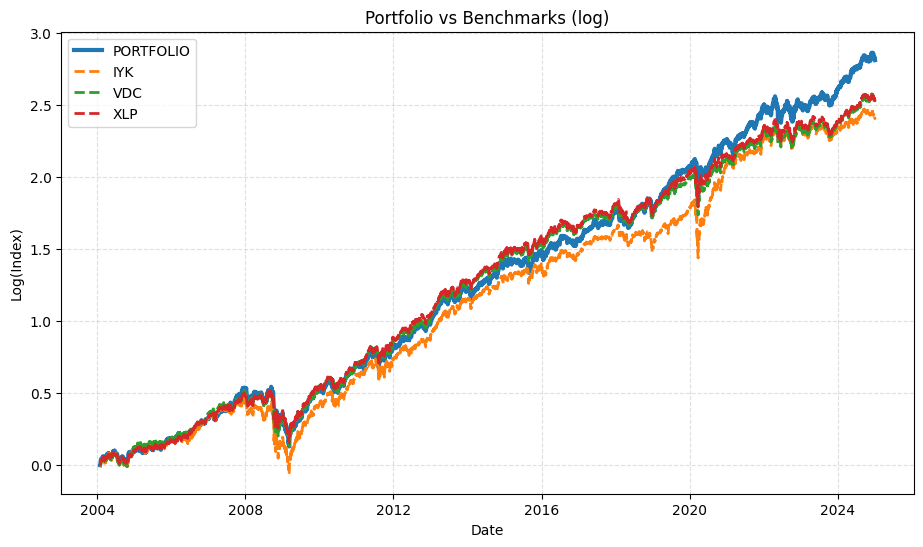

In [82]:
# Plot 4: Portfolio vs Benchmarks (log) - only portfolio and benchmarks
dates = aligned_pl['Date'].to_numpy()
plt.figure(figsize=(11,6))
for name in series_names:
    arr = np.asarray(aligned_pl[name].to_numpy(), dtype=float)
    base = arr[0] if len(arr)>0 else np.nan
    arr = arr if base==0 or np.isnan(base) else arr/base
    arr_log = np.where(arr>0, np.log(arr), np.nan)
    plt.plot(dates, arr_log, label=name, linewidth=3 if name=='PORTFOLIO' else 2, linestyle='--' if name!='PORTFOLIO' else '-')
plt.xlabel('Date')
plt.ylabel('Log(Index)')
plt.title('Portfolio vs Benchmarks (log)')
plt.legend()
plt.grid(True, ls='--', alpha=0.4)
png = results_dir / 'portfolio_vs_benchmarks_log.png'
plt.savefig(png, bbox_inches='tight', dpi=150)
print('Saved:', png)
plt.show()

#### Yearly Returns (Tickers + Benchmarks + Portfolio)

In [83]:
# Plot 5: Yearly returns table PNG (read the CSV produced earlier and render)
csv_path = results_dir / 'annual_returns.csv'
if csv_path.exists():
    yr = pd.read_csv(csv_path, index_col=0)
    disp = (yr * 100).round(2)
    fig, ax = plt.subplots(figsize=(max(8, 0.7*disp.shape[1]), max(2, 0.35*len(disp))))
    ax.axis('off')
    tbl = ax.table(cellText=disp.values, colLabels=disp.columns, rowLabels=disp.index.astype(str), loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(8)
    tbl.scale(1, 1.2)
    png = results_dir / 'annual_returns_table_explicit.png'
    fig.savefig(png, bbox_inches='tight', dpi=150)
    print('Saved:', png)
    plt.show()
else:
    print('annual_returns.csv not found at', csv_path)

annual_returns.csv not found at c:\Users\elibf\Documents\Repositories\MSDS-451-Final\results\annual_returns.csv


### Monte Carlo Simulation

Using random weights to take long and short positions in the equities composing this portfolio, a Monte Carlo simulation is generated to assess the possible future outcomes before building models that are specifically tailored to indicate when certain positions should be aquired or sold.

In [84]:
tables = {
    "PG": pg_data,
    "KO": ko_data,
    "PEP": pep_data,
    "COST": cost_data,
    "WMT": wmt_data,
}

prices_pl = None
for tkr, df in tables.items():
    tmp = df.select([
        pl.col("Date").str.to_datetime(time_zone="UTC").alias("date"),
        pl.col("Close").alias(tkr),
    ])
    if prices_pl is None:
        prices_pl = tmp
    else:
        # Use a unique suffix per join to avoid colliding suffixed column names
        # (Polars will append the suffix to overlapping non-key columns).
        prices_pl = prices_pl.join(tmp, on="date", how="outer", suffix=f"_{tkr}")

prices_pl = prices_pl.sort("date")
prices = prices_pl.to_pandas()
prices["date"] = pd.to_datetime(prices["date"])
prices = prices.set_index("date").sort_index().dropna(how="any")

print(f"'prices' ready: shape={prices.shape}, columns={list(prices.columns)}")
display(prices.tail())

'prices' ready: shape=(6289, 9), columns=['PG', 'date_KO', 'KO', 'date_PEP', 'PEP', 'date_COST', 'COST', 'date_WMT', 'WMT']


,PG,date_KO,KO,date_PEP,PEP,date_COST,COST,date_WMT,WMT
date,,,,,,,,,
2024-12-24 05:00:00+00:00,164.591476,2024-12-24 05:00:00+00:00,61.467873,2024-12-24 05:00:00+00:00,148.375336,2024-12-24 05:00:00+00:00,955.192200,2024-12-24 05:00:00+00:00,91.988403
2024-12-26 05:00:00+00:00,165.780060,2024-12-26 05:00:00+00:00,61.203766,2024-12-26 05:00:00+00:00,148.016083,2024-12-26 05:00:00+00:00,952.522339,2024-12-26 05:00:00+00:00,92.097595
2024-12-27 05:00:00+00:00,165.166290,2024-12-27 05:00:00+00:00,61.086388,2024-12-27 05:00:00+00:00,148.453018,2024-12-27 05:00:00+00:00,936.144531,2024-12-27 05:00:00+00:00,90.976021
2024-12-30 05:00:00+00:00,162.789093,2024-12-30 05:00:00+00:00,60.675556,2024-12-30 05:00:00+00:00,147.316986,2024-12-30 05:00:00+00:00,918.720703,2024-12-30 05:00:00+00:00,89.894157
2024-12-31 05:00:00+00:00,163.334671,2024-12-31 05:00:00+00:00,60.900532,2024-12-31 05:00:00+00:00,147.647095,2024-12-31 05:00:00+00:00,912.803223,2024-12-31 05:00:00+00:00,89.675797


In [85]:
prices = prices[tickers].dropna()

tickers = list(prices.columns)
n_assets = len(tickers)

# Calculate log returns
logrets = np.log(prices / prices.shift(1)).dropna()
mu_daily = logrets.mean().values         # mean daily log returns
cov_daily = logrets.cov().values         # covariance matrix of log returns

# Cholesky Decomposition for correlation
L = np.linalg.cholesky(cov_daily)

rng = np.random.default_rng(SEED)

print("Tickers:", tickers)
print("Number of assets:", n_assets)
print("mu_daily shape:", mu_daily.shape)
print("cov_daily shape:", cov_daily.shape)


Tickers: ['PG', 'KO', 'PEP', 'COST', 'WMT']
Number of assets: 5
mu_daily shape: (5,)
cov_daily shape: (5, 5)


,Mean,Median,VaR_5%,CVaR_5%,N
Long-Only (Daily),"$1,735,094","$1,605,731","$864,234","$745,513",100000.000000
Long+Short (Daily),"$1,600,773","$1,487,654","$845,849","$737,825",100000.000000
Long-Only (Weekly),"$1,741,917","$1,619,871","$862,333","$741,675",100000.000000
Long+Short (Weekly),"$1,607,379","$1,495,401","$842,987","$733,809",100000.000000
Long-Only (Monthly),"$1,736,980","$1,614,513","$860,271","$742,307",100000.000000
Long+Short (Monthly),"$1,592,293","$1,484,827","$842,155","$730,854",100000.000000


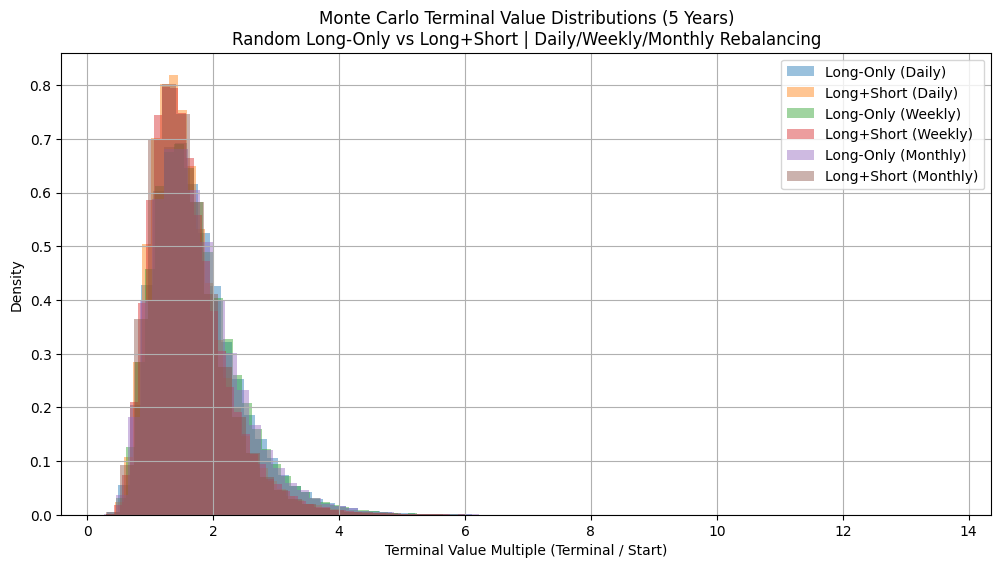

In [86]:
results_summary = []
terminal_store = {}

for label, step in REBALANCE_MAP.items():
    # Long-only random portfolios
    lo_terminals, lo_pp = run_random_portfolio_monte_carlo(
        mu_daily, L, N_DAYS, N_RANDOM_PORTFOLIOS, N_PATHS_PER_PORTFOLIO, rng,
        rebalance_step=step, long_only=True
    )
    s_lo = summarize_terminal(lo_terminals, f"Long-Only ({label})")
    results_summary.append(s_lo)
    terminal_store[f"Long-Only ({label})"] = lo_terminals

    # Long+Short random portfolios
    ls_terminals, ls_pp = run_random_portfolio_monte_carlo(
        mu_daily, L, N_DAYS, N_RANDOM_PORTFOLIOS, N_PATHS_PER_PORTFOLIO, rng,
        rebalance_step=step, long_only=False, net_exposure=NET_EXPOSURE, gross_exposure=GROSS_EXPOSURE
    )
    s_ls = summarize_terminal(ls_terminals, f"Long+Short ({label})")
    results_summary.append(s_ls)
    terminal_store[f"Long+Short ({label})"] = ls_terminals

summary_df = pd.DataFrame(results_summary)
display(summary_df.style.format({"Mean": "${:,.0f}", "Median": "${:,.0f}", "VaR_5%": "${:,.0f}", "CVaR_5%": "${:,.0f}"}))


plt.figure(figsize=(12, 6))
bins = 60
for k, v in terminal_store.items():
    plt.hist(v / START_VALUE, bins=bins, alpha=0.45, density=True, label=k)
plt.title("Monte Carlo Terminal Value Distributions (5 Years)\nRandom Long-Only vs Long+Short | Daily/Weekly/Monthly Rebalancing")
plt.xlabel("Terminal Value Multiple (Terminal / Start)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
png = results_dir / 'rng_monte_carlo.png'
plt.savefig(png, bbox_inches='tight', dpi=150)
plt.show()

Saved plot to c:\Users\elibf\Documents\Repositories\MSDS-451-Final\results\monte_carlo_per_portfolio_risk_return.pdf


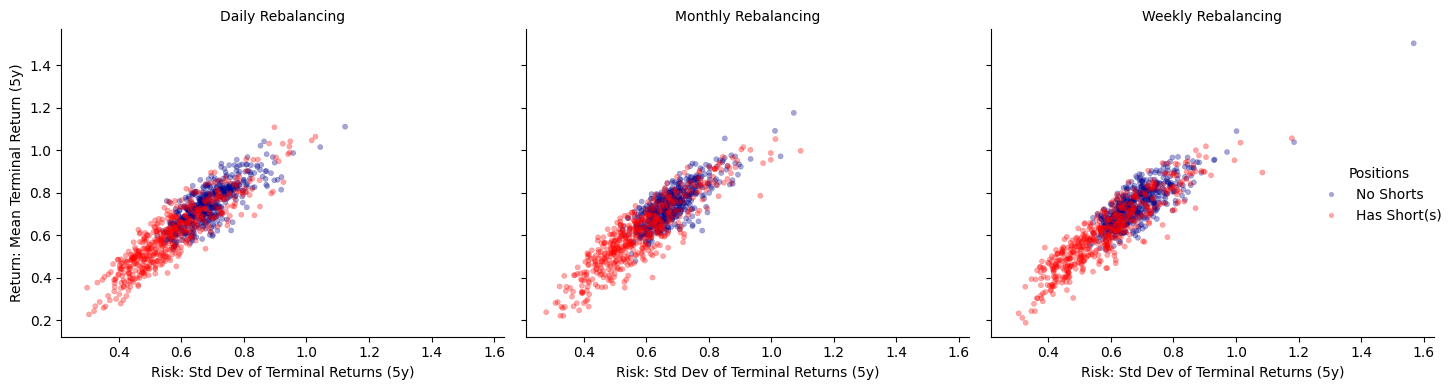

In [ ]:
# Collect per-portfolio stats for each scenario (Daily/Weekly/Monthly × Long-only/Long+Short)
points = []
for freq_label, step in REBALANCE_MAP.items():
    # Long-only portfolios (no shorts)
    _, lo_pp = run_random_portfolio_monte_carlo(
        mu_daily, L, N_DAYS, N_RANDOM_PORTFOLIOS, N_PATHS_PER_PORTFOLIO, rng,
        rebalance_step=step, long_only=True
    )
    lo_pp = lo_pp.copy()
    lo_pp["returnMean"] = lo_pp["mean_terminal"] / START_VALUE - 1.0
    lo_pp["returnSD"]   = lo_pp["std_terminal"]  / START_VALUE
    lo_pp["Positions"]  = "No Shorts"
    lo_pp["InvestmentType"] = freq_label
    points.append(lo_pp[["returnMean", "returnSD", "Positions", "InvestmentType"]])

    # Long+Short portfolios
    _, ls_pp = run_random_portfolio_monte_carlo(
        mu_daily, L, N_DAYS, N_RANDOM_PORTFOLIOS, N_PATHS_PER_PORTFOLIO, rng,
        rebalance_step=step, long_only=False,
        net_exposure=NET_EXPOSURE, gross_exposure=GROSS_EXPOSURE
    )
    ls_pp = ls_pp.copy()
    ls_pp["returnMean"] = ls_pp["mean_terminal"] / START_VALUE - 1.0
    ls_pp["returnSD"]   = ls_pp["std_terminal"]  / START_VALUE
    ls_pp["Positions"]  = "Has Short(s)"
    ls_pp["InvestmentType"] = freq_label
    points.append(ls_pp[["returnMean", "returnSD", "Positions", "InvestmentType"]])

plotting_frame = pd.concat(points, ignore_index=True)
plotting_frame["InvestmentType"] = plotting_frame["InvestmentType"].astype("category")

g = sns.relplot(
    data=plotting_frame,
    x="returnSD",
    y="returnMean",
    hue="Positions",
    col="InvestmentType",
    kind="scatter",
    alpha=0.35,
    s=14,
    edgecolor=None,
    palette={"Has Short(s)": "red", "No Shorts": "darkblue"},
    height=4,
    aspect=1.1
)
g.set_axis_labels("Risk: Std Dev of Terminal Returns (5y)", "Return: Mean Terminal Return (5y)")
g.set_titles(col_template="{col_name} Rebalancing")
plt.tight_layout()

pdf_path = results_dir / "monte_carlo_per_portfolio_risk_return.pdf"
with PdfPages(pdf_path) as pdf:
    pdf.savefig(g.figure, bbox_inches="tight")
print("Saved plot to", pdf_path)

Monte Carlo results demonstrate that random long+short exposure in the consumer staples sector underperforms a long-only strategy both in average and median outcomes, while offering no meaningful improvement in downside protection. This highlights the stability of the consumer staples sector and supports the thesis that a traditional long-only ETF is the optimal structure prior to applying active allocation models.

### Basic Models

In [88]:
# TODO: Implement a basic form of modeling based on the second programming assignment

In [89]:
# TODO: Implement a monte carlo simulation to assess portfolio risk and return characteristics